In [81]:
import numpy as np
from numpy.random import choice
from numba import njit
import time
import matplotlib.pyplot as plt

## Q1: The stock market

(This is about numba)

A Markov Chain is defined as a sequence of random variables where a parameter depends *only* on the preceding value. This is a crucial tool in statistics, widely used in science and beyond (economics for instance).

For instance, the stock market has phases of growing prices (bull), dreasing prices (bear) and recession. This would be a Marov Chain model:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/95/Finance_Markov_chain_example_state_space.svg/400px-Finance_Markov_chain_example_state_space.svg.png)

where the numbers on the arrows indicate the probabily that the next day will be in a given state.

Your task is to simulate the stock market according to this rule. Start from a random state and simulate many many  iterations. If your code is right, the fraction of days in each state should converge. 

Implement a pure-python version and a numba version, and compare speeds. 


In [78]:
#bear = 1, bull = 2, stagnant = 3

def evolveMrkt(state, n):
    mrkt_history = [state]
    
    for i in range(n):
        if state == 1:
            state = choice((1, 2, 3), p=(0.8, 0.15, 0.05))
        elif state == 2:
            state = choice((1, 2, 3), p=(0.075, 0.9, 0.025))
        else:
            state = choice((1, 2, 3), p=(0.25, 0.25, 0.5))
        mrkt_history += [state]
        
    return mrkt_history

@njit
def evolveMrkt_fast(state, n):
    mrkt_history = [state]
    new_state = lambda x, p1, p2 : 1 if(x <= p1) else (2 if(x > (1-p2)) else 3) 
    
    for i in range(n):
        if state == 1:
            state = new_state(np.random.random(), 0.8, 0.15)
        elif state == 2:
            state = new_state(np.random.random(), 0.075, 0.9)
        else:
            state = new_state(np.random.random(), 0.25, 0.25)
        mrkt_history += [state]
    return mrkt_history

In [90]:
N = np.logspace(1, 5, 20, dtype=int)
times = []

for n in N:
    tmp1 = []
    tmp2 = []
    for i in range(5):
        state = choice([1, 2, 3])
        start = time.time()
        tmp = evolveMrkt(state, n)
        tmp1 += [time.time()-start]

        start = time.time()
        tmp = evolveMrkt_fast(state, n)
        tmp2 += [time.time()-start]
        
    times += [[np.mean(tmp1), np.mean(tmp2)]]
times = np.array(times)

Text(0, 0.5, '$t_{pyth}/t_{numba}$')

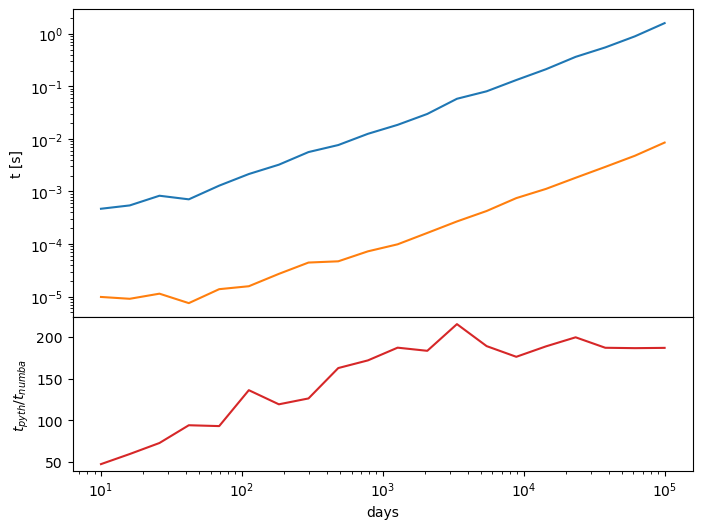

In [102]:
fig = plt.figure(figsize=(8, 6))
fig.tight_layout()
axs = fig.subplots(2,1, height_ratios=[2,1], sharex=True, gridspec_kw={'hspace':0})

axs[0].plot(N, times[:,0], label='pure-pyth')
axs[0].plot(N, times[:,1], label='numba')
axs[0].set_ylabel('t [s]')
axs[0].semilogx()
axs[0].semilogy()

axs[1].plot(N, times[:,0]/times[:,1], color='C3')
axs[1].set_xlabel('days')
axs[1].set_ylabel(r'$t_{pyth}/t_{numba}$')

## Q2: Consistent plotting 

This is about python's dectorators)

Write a decorator for the plots of all your papers. 

- Remember a decorator takes a function. 
- This function in turn should return a matplotlib figure object.
- Before the function is called, the decorator should intialize a matplotlib figure with the options that you like the most (fontsize, ticks, etc etc)
- After the figure it's done, the decorator should save it to pdf.

This is a great hack for your papers! You do this once and for all, and all plots in your paper will be beautifill, all with the same style/fontsize/etc. All you'll need to do is adding `@myplot` to the relevant plotting functions. 
    
The decorator that I use for my papers is available in my python module [skywalker](https://github.com/dgerosa/skywalker).  